# Text Categorization
We will explore how to utilize graph kernels and graph classification techniques in order to enhance natural language processing tasks such as the task of text categorization. Text categorization is the problem of automatically assigning category labels to textual documents. This problem is prevalent in many applications, including automatic news classification and opinion mining in product reviews. We will formulate the problem of text categorization as a graph classification problem, and then use graph kernels and the SVM classifier to solve it.

The following code reads the data from the disk, applies some pre-processing steps (e.g., stemming), and extracts the vocabulary.

In [1]:
import numpy as np
import re
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

def load_file(filename):
    labels = []
    docs =[]

    with open(filename, encoding='utf8', errors='ignore') as f:
        for line in f:
            content = line.split('\t')
            labels.append(content[0])
            docs.append(content[1][:-1])
    
    return docs,labels  


def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower().split()


def preprocessing(docs): 
    preprocessed_docs = []
    n_sentences = 0
    stemmer = PorterStemmer()

    for doc in docs:
        clean_doc = clean_str(doc)
        preprocessed_docs.append([stemmer.stem(w) for w in clean_doc])
    
    return preprocessed_docs
    
    
def get_vocab(train_docs, test_docs):
    vocab = dict()
    
    for doc in train_docs:
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab)

    for doc in test_docs:
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab)
        
    return vocab


path_to_train_set = 'data/train_5500_coarse.label'
path_to_test_set = 'data/TREC_10_coarse.label'

# Read and pre-process train data
train_data, y_train = load_file(path_to_train_set)
train_data = preprocessing(train_data)

# Read and pre-process test data
test_data, y_test = load_file(path_to_test_set)
test_data = preprocessing(test_data)

# Extract vocabulary
vocab = get_vocab(train_data, test_data)
print("Vocabulary size: ", len(vocab))

Vocabulary size:  7186


We will now transform the documents into graphs and perform graph classification. The function *create_graphs_of_words()* that is defined below transforms a list of documents into a list of graphs. We will use the function to generate the train and test graphs. We will set the size of the window to 3.

Example of graph-of-words representation of document


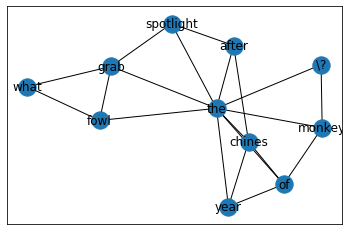

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def create_graphs_of_words(docs, vocab, window_size):
    graphs = list()
    sizes = list()
    degs = list()

    for idx,doc in enumerate(docs):
        G = nx.Graph()
        for i in range(len(doc)):
            if doc[i] not in G.nodes():
                G.add_node(doc[i])
                G.nodes[doc[i]]['label'] = vocab[doc[i]]
        for i in range(len(doc)):
            for j in range(i+1, i+window_size):
                if j < len(doc):
                    G.add_edge(doc[i], doc[j])
        
        graphs.append(G)
    
    return graphs


# Create graph-of-words representations
G_train_nx = create_graphs_of_words(train_data, vocab, 3) 
G_test_nx = create_graphs_of_words(test_data, vocab, 3)

print("Example of graph-of-words representation of document")
nx.draw_networkx(G_train_nx[3], with_labels=True)

We will next utilize the *graph_from_networkx()* function of GraKeL to convert the NetworkX graphs to objects that can be handled by GraKeL. Then, we will initialize a Weisfeiler Lehman subtree kernel and use it to construct the two kernel matrices (i.e., train and test). Next, we will train an SVM classifier and use it to make predictions.

In [3]:
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Transform networkx graphs to grakel representations
G_train = list(graph_from_networkx(G_train_nx, node_labels_tag='label'))
G_test = list(graph_from_networkx(G_test_nx, node_labels_tag='label'))

# Initialize a Weisfeiler-Lehman subtree kernel
gk = WeisfeilerLehman(n_iter=1, normalize=False, base_graph_kernel=VertexHistogram)

# Construct kernel matrices
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Train an SVM classifier and make predictions
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train) 
y_pred = clf.predict(K_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_pred, y_test))

Accuracy: 0.858
